# Family Owned Business Performance
## Annual Business Survey - ETL and Graph Plotting

We wanted to look at family owned businesses and see how they compare with businesses that are not family owned. This notebook can be run in its entirety to reload the data and reproduce the graphs. Make sure to add your API key to the config file.

### Datasets
#### 2019 Annual Business Survey by U.S Census Bureau

**Characteristics of Businesses**

api.census.gov/data/2018/abscb.html

**Characteristics of Business Owners**

api.census.gov/data/2018/abscbo.html



### Questions

What can we learn about business owners of family-owned businesses vs non-family-owned businesses?
- How do the owners of family-owned businesses vs non-family-owned businesses compare by sex?
- How do the owners of family-owned businesses vs non-family-owned businesses compare by race?
- How do owners rate the importance of carrying on the family business?

What differences can we learn about the size and performance of family-owned businesses vs non-family-owned businesses?
- How does firm revenue size category break down between family owned and non-family-owned businesses?
- Do family-owned businesses have more employees?
- How does the number of employees break down between family-owned and non-family-owned businesses?
- How long have family-owned businesses been operating?

What else can we learn about family-owned businesses?
- Are family-owned businesses more concentrated in certain industries?
- Which states have the most family-owned businesses?
- Which states have the highest percentage of family-owned businesses?
- Which states have the most employees per family-owned business?
- How does the average annual payroll of family-owned businesses compare per state?

In [70]:
# Import Needed Libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from config import api_key
import plotly.graph_objects as go
import requests
import numpy as np


To extract, we first queried the API using a link to the Census API website. Then we dropped the first row and make it the header for the table. We also switched the FIRMPDEMP (number of firms) into an integer and NAME into a string.

In [5]:
company = pd.read_json(f'https://api.census.gov/data/2018/abscs?get=NAME,FIRMPDEMP&for=us&NAICS2017=00&key={api_key}')
company.columns = company.iloc[0]
company =  company.iloc[1:].reset_index(drop=True)
company['NAME'] = company['NAME'].astype(str)
company['FIRMPDEMP'] = company['FIRMPDEMP'].astype(int)
company
# Returns Total Firms in US

,NAME,FIRMPDEMP,NAICS2017,us
0,United States,5722142,00,1


Much like the last query, we extracted via the API link. Renamed columns and switched variable types. The header fix was needed on all of our queries to get the data to be usable.


In [6]:
business = pd.read_json(f'http://api.census.gov/data/2018/abscb?get=BUSCHAR_LABEL,QDESC,QDESC_LABEL,FIRMPDEMP,EMP&for=us&BUSCHAR=BM&BUSCHAR=BN&key={api_key}')

# Fix Headers
business.columns = business.iloc[0]
business = business.iloc[1:].reset_index(drop=True)
# Rename Columns
business.rename(columns={'FIRMPDEMP':'FIRM_COUNT','BUSCHAR_LABEL':'Ownership'}, inplace=True)
# Change Data Types
business['FIRM_COUNT'] = business['FIRM_COUNT'].astype(int)
business['EMP'] = business['EMP'].astype(int)
business
# Shows US Family and Non Family Owned Businesses

,Ownership,QDESC,QDESC_LABEL,FIRM_COUNT,EMP,BUSCHAR,us
0,Family-owned,B02,FAMOWN,787775,8048586,BM,1
1,Not family-owned,B02,FAMOWN,1893857,14397079,BN,1


We calculated a new field with the average and added it to the business dataframe


In [7]:
business['avg_emp_per_firm'] = business['EMP'] / business['FIRM_COUNT']
business

,Ownership,QDESC,QDESC_LABEL,FIRM_COUNT,EMP,BUSCHAR,us,avg_emp_per_firm
0,Family-owned,B02,FAMOWN,787775,8048586,BM,1,10.216859
1,Not family-owned,B02,FAMOWN,1893857,14397079,BN,1,7.601988


We merged the two dataframes together and kept the columns we needed.

In [8]:
cs_bc = company.merge(business, how='inner', on=["us"])
cs_bc = cs_bc[['NAME','Ownership','FIRMPDEMP','us','FIRM_COUNT','EMP','avg_emp_per_firm']]

cs_bc

,NAME,Ownership,FIRMPDEMP,us,FIRM_COUNT,EMP,avg_emp_per_firm
0,United States,Family-owned,5722142,1,787775,8048586,10.216859
1,United States,Not family-owned,5722142,1,1893857,14397079,7.601988


Text(0.5, 1.0, 'Average Employess per Firm, Family and Not Family Owned')

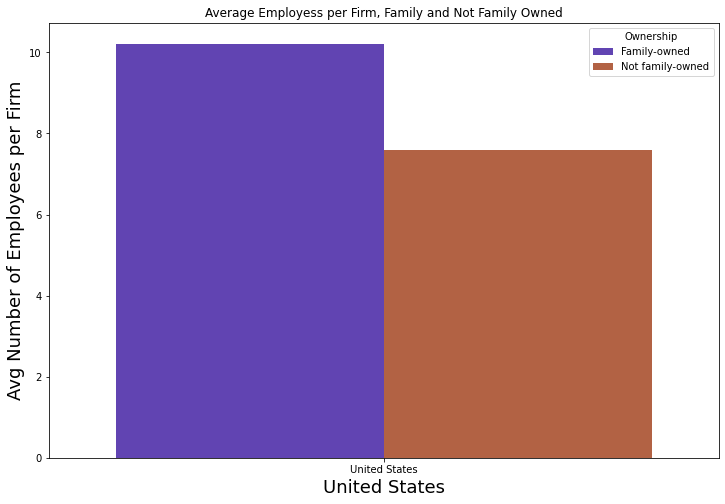

In [12]:
# Bar Chart comparing Family-Owned and Not Family-Owned Businesses in the US
plt.figure(figsize = (12,8))
ax = sns.barplot(x=cs_bc[0:50]['NAME'], y=cs_bc[0:50]['avg_emp_per_firm'], hue='Ownership', 
    palette=['#5932C4', '#C45932'], data=cs_bc)
ax.set_xticklabels(ax.get_xticklabels())
ax.set_xlabel('United States', size=18)
ax.set_ylabel('Avg Number of Employees per Firm', size=18)
ax.set_title('Average Employess per Firm, Family and Not Family Owned')

We called the API to get the business characteristics data for the length of business existence/survival.

In [13]:
business_survival = pd.read_json(f'http://api.census.gov/data/2018/abscb?get=BUSCHAR_LABEL,QDESC,QDESC_LABEL,YIBSZFI_LABEL,FIRMPDEMP,EMP&for=us&BUSCHAR=BM&BUSCHAR=BN&YIBSZFI!=001&key={api_key}')
# Fixed Headers
business_survival.columns = business_survival.iloc[0]
business_survival = business_survival.iloc[1:].reset_index(drop=True)
# Renamed Columns
business_survival.rename(columns={'FIRMPDEMP':'FIRM_COUNT','BUSCHAR_LABEL':'Ownership'}, inplace=True)
# Changed Data Types
business_survival['FIRM_COUNT'] = business_survival['FIRM_COUNT'].astype(int)
business_survival['EMP'] = business_survival['EMP'].astype(int)
business_survival = business_survival[['Ownership','YIBSZFI_LABEL','FIRM_COUNT','us']]
# Changed Labels to Make them Shorter
business_survival.loc[ business_survival['YIBSZFI_LABEL'] == 'Firms with 2 to 3 years in business', 'YIBSZFI_LABEL'] = '2 to 3 Years'
business_survival.loc[ business_survival['YIBSZFI_LABEL'] == 'Firms with 4 to 5 years in business', 'YIBSZFI_LABEL'] = '4 to 5 Years'
business_survival.loc[ business_survival['YIBSZFI_LABEL'] == 'Firms with 6 to 10 years in business', 'YIBSZFI_LABEL'] = '6 to 10 Years'
business_survival.loc[ business_survival['YIBSZFI_LABEL'] == 'Firms with 11 to 15 years in business', 'YIBSZFI_LABEL'] = '11 to 15 Years'
business_survival.loc[ business_survival['YIBSZFI_LABEL'] == 'Firms with 16 or more years in business', 'YIBSZFI_LABEL'] = '16 or More Years'
business_survival.loc[ business_survival['YIBSZFI_LABEL'] == 'Firms with less than 2 years in business', 'YIBSZFI_LABEL'] = 'Less Than 2 Years'

business_survival.head(2)

,Ownership,YIBSZFI_LABEL,FIRM_COUNT,us
0,Family-owned,2 to 3 Years,84089,1
1,Not family-owned,2 to 3 Years,242514,1


Text(0.5, 1.0, 'Length of Time in Business, Family and Not Family Owned')

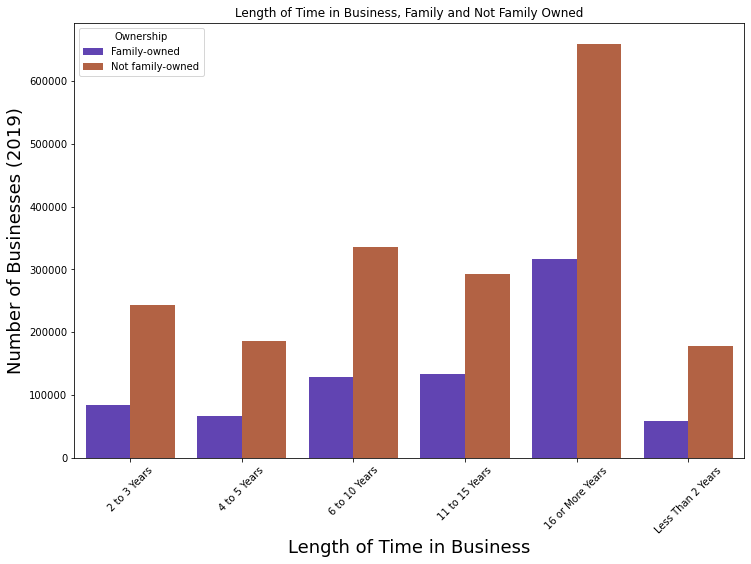

In [15]:
# Bar plot for Length of Time in Business, Family and Not Family Owned
plt.figure(figsize = (12,8))
ax = sns.barplot(x=business_survival['YIBSZFI_LABEL'], y=business_survival['FIRM_COUNT'], hue='Ownership', 
    palette=['#5932C4', '#C45932'], data=business_survival)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
ax.set_xlabel('Length of Time in Business', size=18)
ax.set_ylabel('Number of Businesses (2019)', size=18)
ax.set_title('Length of Time in Business, Family and Not Family Owned')

We loaded up a business characteristics query to get the number of family owned businesses in each industry.

In [17]:
business_industry = pd.read_json(f'http://api.census.gov/data/2018/abscb?get=BUSCHAR_LABEL,QDESC_LABEL,NAICS2017_LABEL,FIRMPDEMP&for=us&BUSCHAR=BM&QDESC=B02&NAICS2017!=00&key={api_key}')
# Fixed Headers
business_industry.columns = business_industry.iloc[0]
business_industry = business_industry.iloc[1:].reset_index(drop=True)
# Changed data type and reduced columns
business_industry['FIRMPDEMP'] = business_industry['FIRMPDEMP'].astype(int)
business_industry[['BUSCHAR_LABEL','NAICS2017_LABEL','FIRMPDEMP','NAICS2017','us']]

business_industry.head(2)

,BUSCHAR_LABEL,QDESC_LABEL,NAICS2017_LABEL,FIRMPDEMP,BUSCHAR,QDESC,NAICS2017,us
0,Family-owned,FAMOWN,"Agriculture, forestry, fishing and hunting",4760,BM,B02,11,1
1,Family-owned,FAMOWN,"Mining, quarrying, and oil and gas extraction",2868,BM,B02,21,1


In [19]:
# Sorted values for horizontal bar graph
sorted_business_industry = business_industry.sort_values(by=['FIRMPDEMP'], ascending=False)

Text(0.5, 1.0, 'Family Owned Businesses By Industry')

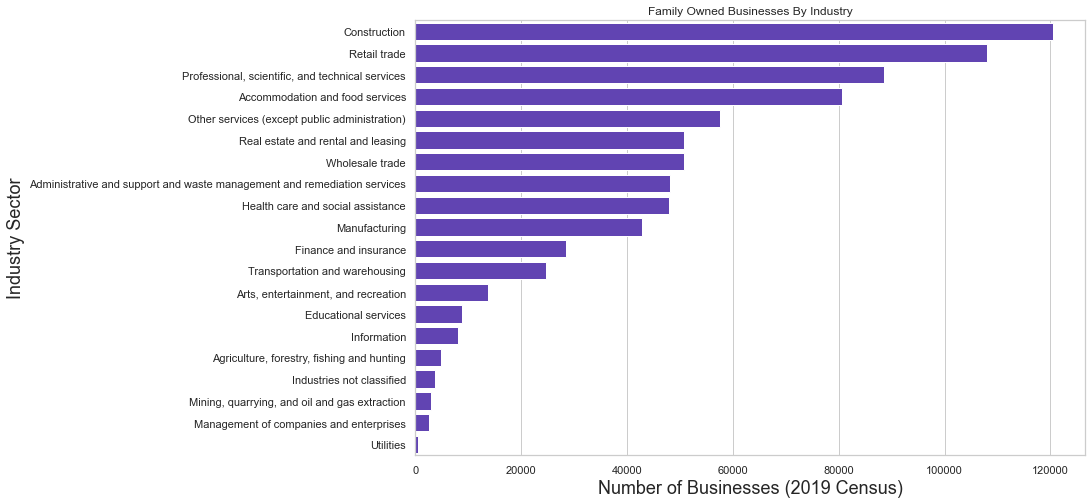

In [20]:
# Created a Horizontal Bar Chart for Family Owned Businesses By Industry
sns.set_theme(style='whitegrid')
plt.figure(figsize = (12,8))
# plt.bar(color='#5932C4')
ax = sns.barplot(x=sorted_business_industry['FIRMPDEMP'], y=sorted_business_industry['NAICS2017_LABEL'], color='#5932C4', data=sorted_business_industry)
# ax.set_xticklabels(ax.get_xticklabels())
ax.set_xlabel('Number of Businesses (2019 Census)', size=18)
ax.set_ylabel('Industry Sector', size=18)
ax.set_title('Family Owned Businesses By Industry')

### Bar Charts: Family Owned vs. Non Family Owned Business Stats
- Employment Size Categories
- Revenue Size Categories
- Years in Business Categories

In [22]:
def cleanCensusAPIData(url):
    response = requests.get(url)
    raw = response.text
    rawlist = raw.split(',\n')
    newlist = []
    for i in rawlist:
        a = i.strip('[]""')
        b = a.split('","')
        newlist.append(b)
    df = pd.DataFrame(newlist[1:], columns=newlist[0])
    return df

# gets API link and calls previous function to spit out dataframe
def getAPI(dataset, params, geolocation='state', ic='00'):
    apilink = (f"https://api.census.gov/data/2018/{dataset}?get={params}&for={geolocation}:*&NAICS2017={ic}")
    df = cleanCensusAPIData(apilink)
    return df

In [23]:
# finds characteristics of business data, 
variables = "NAME,GEO_ID,PAYANN,EMP,QDESC,QDESC_LABEL,BUSCHAR,BUSCHAR_LABEL,FIRMPDEMP,YIBSZFI,RCPSZFI,EMPSZFI"
abscb = getAPI("abscb",variables,geolocation='us')

# filters for family owned and non family owned stats
familyowned = abscb[((abscb['BUSCHAR_LABEL']=='Family-owned') | (abscb['BUSCHAR_LABEL']=='Not family-owned'))]

# converting data type and changing column name for plotting
familyowned['FIRMPDEMP'] = familyowned['FIRMPDEMP'].astype(int)
familyowned = familyowned.rename(columns={'BUSCHAR_LABEL':'Ownership'})
familyowned.head(2)

C:\Users\nmorr\AppData\Local\Temp\ipykernel_19756\2200318513.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  familyowned['FIRMPDEMP'] = familyowned['FIRMPDEMP'].astype(int)


,NAME,GEO_ID,PAYANN,EMP,QDESC,QDESC_LABEL,BUSCHAR,Ownership,FIRMPDEMP,YIBSZFI,RCPSZFI,EMPSZFI,NAICS2017,us
204,United States,0100000US,16604437,545655,B02,FAMOWN,BM,Family-owned,84089,318,001,001,00,1
205,United States,0100000US,46678795,1473911,B02,FAMOWN,BN,Not family-owned,242514,318,001,001,00,1


In [24]:
# (before i realized there was a EMPSZFI_LABEL column)
# generates labels for each code in EMPSZFI, merges into main dataframe 
empszfi_desc = ['All firms',
           'no employees',
           '1 to 4 employees',
           '5 to 9 employees',
           '10 to 19 employees',
           '20 to 49 employees',
           '50 to 99 employees',
           '100 to 249 employees',
           '250 to 499 employees',
           '500 employees or more']
empszfi_code = ['001','611','612','620','630','641','642','651','652','657']
empszfi_dict = {'EMPSZFI':empszfi_code,'EMPSZFILabel':empszfi_desc}
empszfi = pd.DataFrame(empszfi_dict)
familyowned = familyowned.merge(empszfi,how='inner',on='EMPSZFI')
empszfi.head(3)

,EMPSZFI,EMPSZFILabel
0,001,All firms
1,611,no employees
2,612,1 to 4 employees


In [36]:
# (before i realized there was a RCPSZFI_LABEL column)
# generates labels for each code in RCPSZFI, merges into main dataframe 
rcpszfi_desc = ['All firms',
                'less than \$5,000',
                '\$5,000 to \$9,999',
                '\$10,000 to \$24,999',
                '\$25,000 to \$49,999',
                '\$50,000 to \$99,999',
                '\$100,000 to \$249,999',
                '\$250,000 to \$499,999',
                '\$500,000 to \$999,999',
                '\$1,000,000 or more']
rcpszfi_code = ['001','511','518','519','521','522','523','525','531','532']
rcpszfi_dict = {'RCPSZFI':rcpszfi_code,'RCPSZFILabel':rcpszfi_desc}
rcpszfi = pd.DataFrame(rcpszfi_dict)
familyowned = familyowned.merge(rcpszfi,how='inner',on='RCPSZFI')
rcpszfi.head(3)

,RCPSZFI,RCPSZFILabel
0,001,All firms
1,511,"less than \$5,000"
2,518,"\$5,000 to \$9,999"


In [32]:
# (before i realized there was a YIBSZFI_LABEL column)
# generates labels for each code in YIBSZFI, merges into main dataframe 
yibszfi_desc = ['All firms',
           'less than 2 years',
           '2 to 3 years',
           '4 to 5 years',
           '6 to 10 years',
           '11 to 15 years',
           '16 or more years']
yibszfi_code = ['001','311','318','319','321','322','323']
yibszfi_dict = {'YIBSZFI':yibszfi_code,'YIBSZFILabel':yibszfi_desc}
yibszfi = pd.DataFrame(yibszfi_dict)
familyowned = familyowned.merge(yibszfi,how='inner',on='YIBSZFI')

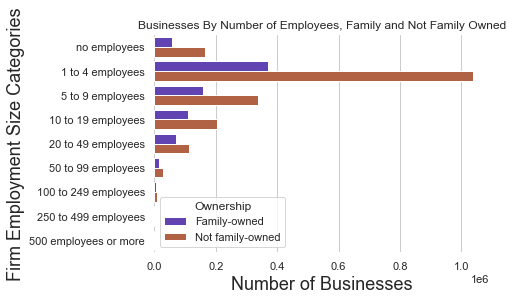

In [33]:
# filters for all years in business, all revenue sizes, and not all employee sizes
familyowned_emp = familyowned[((familyowned['YIBSZFI']=='001') & (familyowned['RCPSZFI']=='001') & (familyowned['EMPSZFI']!='001'))]

# graph compares firm employment sizes with family owned and non family owned
sns.set_theme(style="whitegrid")
ax = sns.barplot(x='FIRMPDEMP', 
                 y='EMPSZFILabel', 
                 hue='Ownership',
                 palette=['#5932C4', '#C45932'],
                 data=familyowned_emp, 
                 # orient='h'
                )
ax.set_xlabel('Number of Businesses', size=18)
ax.set_ylabel('Firm Employment Size Categories', size=18)
ax.set_title('Businesses By Number of Employees, Family and Not Family Owned')
sns.despine(left=True, bottom=True)

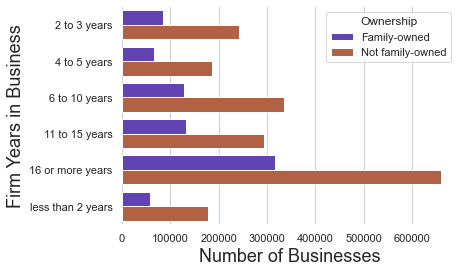

In [34]:
# filters for not all years in business, all revenue sizes, and all employee sizes
familyowned_yib = familyowned[((familyowned['YIBSZFI']!='001') & (familyowned['EMPSZFI']=='001') & (familyowned['RCPSZFI']=='001'))]

# graph compares years in business with family owned and non family owned
sns.set_theme(style="whitegrid")
ax = sns.barplot(x='FIRMPDEMP', 
                 y='YIBSZFILabel', 
                 hue='Ownership',
                 palette=['#5932C4', '#C45932'],
                 data=familyowned_yib, 
                 # orient='h'
                )
ax.set_xlabel('Number of Businesses', size=18)
ax.set_ylabel('Firm Years in Business', size=18)
sns.despine(left=True, bottom=True)

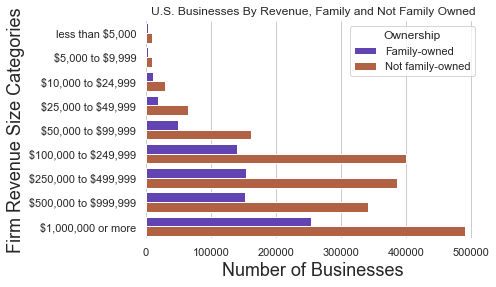

In [38]:
# filters for all years in business, not all revenue sizes, and all employee sizes
familyowned_rcp = familyowned[((familyowned['RCPSZFI']!='001') & (familyowned['EMPSZFI']=='001') & (familyowned['YIBSZFI']=='001'))]

# graph compares firm revenue sizes with family owned and non family owned
ax = sns.barplot(x='FIRMPDEMP', 
                 y='RCPSZFILabel', 
                 hue='Ownership',
                 palette=['#5932C4', '#C45932'],
                 data=familyowned_rcp, 
                 # orient='h'
                )
ax.set_xlabel('Number of Businesses', size=18)
ax.set_ylabel('Firm Revenue Size Categories', size=18)
ax.set_title('U.S. Businesses By Revenue, Family and Not Family Owned')
sns.despine(left=True, bottom=True)

We once again queried the Census API.

In [39]:
# Import and compare race for Family Owned vs not Family Owned for the US
us_bus_chars_race = pd.read_json(f'http://api.census.gov/data/2018/abscb?get=NAME,GEO_ID,BUSCHAR_LABEL,QDESC,QDESC_LABEL,EMP,RACE_GROUP,RACE_GROUP_LABEL,PAYANN,FIRMPDEMP&for=us:*&RACE_GROUP=30&RACE_GROUP=40&RACE_GROUP=50&RACE_GROUP=60&RACE_GROUP=70&RACE_GROUP=91&BUSCHAR=BM&BUSCHAR=BN&key={api_key}')
us_bus_chars_race.columns = us_bus_chars_race.iloc[0]
us_bus_chars_race = us_bus_chars_race.iloc[1:].reset_index(drop=True)

In [41]:
#collect only the variables we need
family_owner_race = us_bus_chars_race[['BUSCHAR','FIRMPDEMP','RACE_GROUP_LABEL']]
#Change the FIRMPDEMP to an integer
family_owner_race['FIRMPDEMP'] = family_owner_race['FIRMPDEMP'].astype(int)
#Rename each column
family_owner_race.columns = ['Ownership', 'Number of Firms', 'Race']
#Rename the values to be more easily understandable
family_owner_race.loc[family_owner_race['Ownership'] == 'BM', 'Ownership'] = 'Family-Owned'
family_owner_race.loc[family_owner_race['Ownership'] == 'BN', 'Ownership'] = 'Not Family-Owned'
family_owner_race.shape

C:\Users\nmorr\AppData\Local\Temp\ipykernel_19756\206028675.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  family_owner_race['FIRMPDEMP'] = family_owner_race['FIRMPDEMP'].astype(int)


(12, 3)

Text(0.5, 0, 'Number of Firms (in millions)')

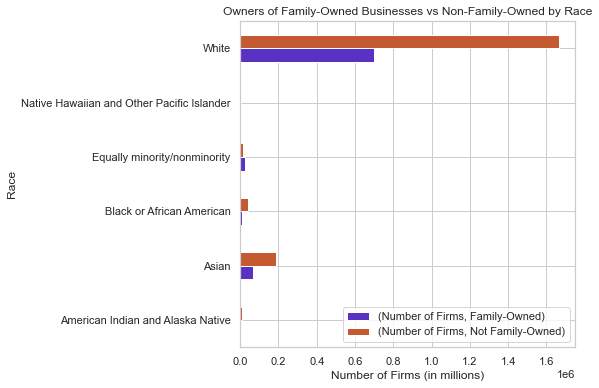

In [42]:
# Create a pivot table and bar chart for family owned business by race
pivot = pd.pivot_table(data = family_owner_race, index=['Race'], values=['Number of Firms'], columns=['Ownership'])
pivot.head(6)
ax = pivot.plot.barh(title = 'Owners of Family-Owned Businesses vs Non-Family-Owned by Race', figsize =(6,6), color = ['#5932C4','#C45932'])
ax.set_ylabel('Race')
ax.legend(loc = 'lower right')
#ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)
ax.set_xlabel('Number of Firms (in millions)')

### Owners of Family Owned Businesses By Sex

In [43]:
# Import and compare sex for Family Owned vs not Family Owned for the US
us_bus_chars_sex = pd.read_json(f'http://api.census.gov/data/2018/abscb?get=NAME,GEO_ID,BUSCHAR_LABEL,QDESC,QDESC_LABEL,EMP,SEX_LABEL,PAYANN,FIRMPDEMP&for=us:*&SEX=002&SEX=003&SEX=004&BUSCHAR=BM&BUSCHAR=BN&key={api_key}')
# Fixes Headers
us_bus_chars_sex.columns = us_bus_chars_sex.iloc[0]
us_bus_chars_sex = us_bus_chars_sex.iloc[1:].reset_index(drop=True)

In [44]:
#collect only the variables we need
family_owner_sex = us_bus_chars_sex[['BUSCHAR','FIRMPDEMP','SEX_LABEL']]
#Change the FIRMPDEMP to an integer
family_owner_sex['FIRMPDEMP'] = family_owner_sex['FIRMPDEMP'].astype(int)
#Rename each column
family_owner_sex.columns = ['Ownership', 'Number of Firms', 'Sex']
#Rename the values to be more easily understandable
family_owner_sex.loc[family_owner_sex['Ownership'] == 'BM', 'Ownership'] = 'Family-Owned'
family_owner_sex.loc[family_owner_sex['Ownership'] == 'BN', 'Ownership'] = 'Not Family-Owned'

C:\Users\nmorr\AppData\Local\Temp\ipykernel_19756\2739431582.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  family_owner_sex['FIRMPDEMP'] = family_owner_sex['FIRMPDEMP'].astype(int)


Text(0, 0.5, 'Number of Firms (in millions)')

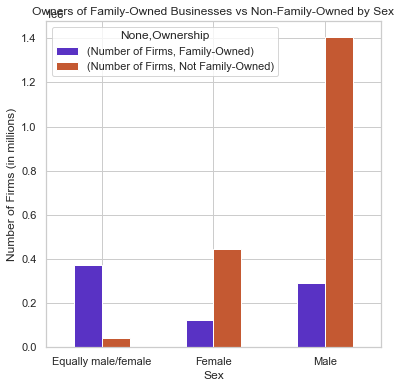

In [45]:
# Create a pivot table and bar chart for family owned business by race
pivot = pd.pivot_table(data = family_owner_sex, index=['Sex'], values=['Number of Firms'], columns=['Ownership'])
ax = pivot.plot.bar(title = 'Owners of Family-Owned Businesses vs Non-Family-Owned by Sex', figsize =(6,6), color = ['#5932C4','#C45932'])
ax.set_xlabel('Sex')
ax.set_xticklabels(ax.get_xticklabels(),rotation = 0)
ax.set_ylabel('Number of Firms (in millions)')

### Maps: Family Owned Stats per State
- Average number of employees per business
- Average annual payroll per business
- Number of firms

In [46]:
# grabs characteristics of business data
business = pd.read_json(r'http://api.census.gov/data/2018/abscb?get=GEO_ID,BUSCHAR_LABEL,QDESC,QDESC_LABEL,EMP,VET_GROUP,PAYANN,FIRMPDEMP&for=state&BUSCHAR=BM&key=bccfff37a66ca0c564d5d5d80d0236771b334f9b')
business.columns = business.iloc[0]
business = business.iloc[1:].reset_index(drop=True)
business.head(3)

,GEO_ID,BUSCHAR_LABEL,QDESC,QDESC_LABEL,EMP,VET_GROUP,PAYANN,FIRMPDEMP,BUSCHAR,state
0,0400000US28,Family-owned,B02,FAMOWN,45125,001,1400709,4744,BM,28
1,0400000US29,Family-owned,B02,FAMOWN,196071,001,6936552,18034,BM,29
2,0400000US30,Family-owned,B02,FAMOWN,33990,001,1063507,6419,BM,30


In [48]:
# trying to map state codes to GEO_ID, had to look up census geocodes for state
stateAbbrev = ['AL', 'AK', 'AZ', 'AR', 'CA', 'CO', 'CT', 'DE', 'DC', 'FL', 
              'GA', 'HI', 'ID', 'IL', 'IN', 'IA', 'KS', 'KY', 'LA', 'ME', 
              'MD', 'MA', 'MI', 'MN', 'MS', 'MO', 'MT', 'NE', 'NV', 'NH', 
              'NJ', 'NM', 'NY', 'NC', 'ND', 'OH', 'OK', 'OR', 'PA', 'RI', 
              'SC', 'SD', 'TN', 'TX', 'UT', 'VT', 'VA', 'WA', 'WV', 'WI', 'WY']
stateID = [1, 2, 4, 5, 6, 8, 9, 10, 
           11, 12, 13, 15, 16, 17, 18, 19, 20, 
           21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 
           31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 
           41, 42, 44, 45, 46, 47, 48, 49, 50, 
           51, 53, 54, 55, 56]
stateGEOID = list(map(lambda x: '0400000US{}'.format(str(x).zfill(2)), stateID))
stateCodes = {'Abbrev':stateAbbrev,'GEO_ID':stateGEOID}
stateCodes = pd.DataFrame(stateCodes)
stateCodes.head()

,Abbrev,GEO_ID
0,AL,0400000US01
1,AK,0400000US02
2,AZ,0400000US04
3,AR,0400000US05
4,CA,0400000US06


We merged the business dataframe with the state table we created

In [49]:
business_statename = business.merge(stateCodes, how='left', on='GEO_ID')
business_statename.head(2)

,GEO_ID,BUSCHAR_LABEL,QDESC,QDESC_LABEL,EMP,VET_GROUP,PAYANN,FIRMPDEMP,BUSCHAR,state,Abbrev
0,0400000US28,Family-owned,B02,FAMOWN,45125,001,1400709,4744,BM,28,MS
1,0400000US29,Family-owned,B02,FAMOWN,196071,001,6936552,18034,BM,29,MO


In [53]:
# converting datatypes to int
business_statename_plot = business_statename[['state','Abbrev','FIRMPDEMP','EMP','PAYANN']]
business_statename_plot['FIRMPDEMP'] = business_statename_plot['FIRMPDEMP'].astype(int)
business_statename_plot['EMP'] = business_statename_plot['EMP'].astype(int)
business_statename_plot['PAYANN'] = business_statename_plot['PAYANN'].astype(float)
# making columns for the averages (average employee count, average payroll)
business_statename_plot['UnitEMP'] = business_statename_plot['EMP']/business_statename_plot['FIRMPDEMP']
business_statename_plot['UnitPAYANN'] = business_statename_plot['PAYANN']*1000/business_statename_plot['FIRMPDEMP']

business_statename_plot.head()

C:\Users\nmorr\AppData\Local\Temp\ipykernel_19756\2590665057.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  business_statename_plot['FIRMPDEMP'] = business_statename_plot['FIRMPDEMP'].astype(int)
C:\Users\nmorr\AppData\Local\Temp\ipykernel_19756\2590665057.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  business_statename_plot['EMP'] = business_statename_plot['EMP'].astype(int)
C:\Users\nmorr\AppData\Local\Temp\ipykernel_19756\2590665057.py:5: SettingWithCopyWarning: 
A value is trying to be set on

,state,Abbrev,FIRMPDEMP,EMP,PAYANN,UnitEMP,UnitPAYANN
0,28,MS,4744,45125,1400709.0,9.512015,295259.064081
1,29,MO,18034,196071,6936552.0,10.872297,384637.462571
2,30,MT,6419,33990,1063507.0,5.295217,165681.102976
3,31,NE,8466,67532,2538668.0,7.976849,299866.288684
4,32,NV,5855,55106,1720501.0,9.411785,293851.579846


We queried the API to get the total firms per state

In [54]:
business_totals = pd.read_json(f'http://api.census.gov/data/2018/abscb?get=GEO_ID,BUSCHAR_LABEL,QDESC,QDESC_LABEL,EMP,VET_GROUP,PAYANN,FIRMPDEMP&for=state&BUSCHAR=BO&key={api_key}')
business_totals.columns = business_totals.iloc[0]
business_totals = business_totals.iloc[1:].reset_index(drop=True)
business_totals = business_totals.rename(columns={'FIRMPDEMP':'totalFirms'})
business_totals = business_totals[['totalFirms','state']]
business_totals['totalFirms'] = business_totals['totalFirms'].astype(int)
business_totals.head()

,totalFirms,state
0,16501,28
1,51069,29
2,15801,30
3,21697,31
4,19435,32


Then, we merged the total firms with the business_statename dataframe

In [55]:
business_statename_plot = business_statename_plot.merge(business_totals,how='inner',on='state')
business_statename_plot['PercentFamilyOwned'] = business_statename_plot['FIRMPDEMP']*100/business_statename_plot['totalFirms']
business_statename_plot.head()

,state,Abbrev,FIRMPDEMP,EMP,PAYANN,UnitEMP,UnitPAYANN,totalFirms,PercentFamilyOwned
0,28,MS,4744,45125,1400709.0,9.512015,295259.064081,16501,28.749773
1,29,MO,18034,196071,6936552.0,10.872297,384637.462571,51069,35.313008
2,30,MT,6419,33990,1063507.0,5.295217,165681.102976,15801,40.624011
3,31,NE,8466,67532,2538668.0,7.976849,299866.288684,21697,39.019219
4,32,NV,5855,55106,1720501.0,9.411785,293851.579846,19435,30.126061


In [62]:
# Annual Payroll per Family Owned Business by State, USA

fig = go.Figure(data=go.Choropleth(
    locations=business_statename_plot['Abbrev'], # Spatial coordinates
    z = business_statename_plot['UnitPAYANN'].astype(float), # Data to be color-coded
    locationmode = 'USA-states', # set of locations match entries in `locations`
    colorscale = 'purples',
    colorbar_title = "Annual Payroll ($)",
))

fig.update_layout(
    title_text = 'Annual Payroll per Family Owned Business by State, USA',
    geo_scope='usa', # limite map scope to USA
)

fig.show()

In [61]:
# Average Employees per Family Owned Business by State, USA

fig = go.Figure(data=go.Choropleth(
    locations=business_statename_plot['Abbrev'], # Spatial coordinates
    z = business_statename_plot['UnitEMP'].astype(float), # Data to be color-coded
    locationmode = 'USA-states', # set of locations match entries in `locations`
    colorscale = 'purples',
    colorbar_title = "Employees",
))

fig.update_layout(
    title_text = 'Average Employees per Family Owned Business by State, USA',
    geo_scope='usa', # limite map scope to USA
)

fig.show()

In [60]:
# Number of Family Owned Businesses by State, USA

fig = go.Figure(data=go.Choropleth(
    locations=business_statename_plot['Abbrev'], # Spatial coordinates
    z = business_statename_plot['PercentFamilyOwned'].astype(float), # Data to be color-coded
    locationmode = 'USA-states', # set of locations match entries in `locations`
    colorscale = 'purples',
    colorbar_title = "% of Total Businesses",
))

fig.update_layout(
    title_text = 'Percent of Family Owned Businesses by State, USA',
    geo_scope='usa', # limite map scope to USA
)

fig.show()

In [59]:
fig = go.Figure(data=go.Choropleth(
    locations=business_statename_plot['Abbrev'], # Spatial coordinates
    z = business_statename_plot['FIRMPDEMP'].astype(float), # Data to be color-coded
    locationmode = 'USA-states', # set of locations match entries in `locations`
    colorscale = 'purples',
    colorbar_title = "Businesses",
))

fig.update_layout(
    title_text = 'Number of Family Owned Businesses by State, USA',
    geo_scope='usa', # limite map scope to USA
)

fig.show()

### Barplot: Reason for ownership of business
- Continuing a family business

Queried from the business owner characteristics API

In [63]:
owner = pd.read_json(f'https://api.census.gov/data/2018/abscbo?get=NAME,OWNPDEMP,QDESC,OWNCHAR,OWNCHAR_LABEL,OWNER_SEX_LABEL,OWNER_RACE_LABEL&for=us&NAICS2017=00&key={api_key}')
# Fixed Headers
owner.columns = owner.iloc[0]
owner =  owner.iloc[1:].reset_index(drop=True)
owner['OWNPDEMP'] = owner['OWNPDEMP'].astype(int)

familyowned = owner[['OWNPDEMP','OWNCHAR']]
familyowned = familyowned[familyowned['OWNCHAR'].isin(['OR1N','OR1S','OR1V'])]
labelmap = {'OR1N':'Not important','OR1S':'Somewhat important','OR1V':'Very important'}
familyowned['Label'] = familyowned['OWNCHAR'].map(lambda x: labelmap.get(x))
familyowned

,OWNPDEMP,OWNCHAR,Label
82,2717912,OR1N,Not important
83,602435,OR1S,Somewhat important
84,752938,OR1V,Very important


Text(0.5, 1.0, 'Importance for Owners to Carry On Family Business')

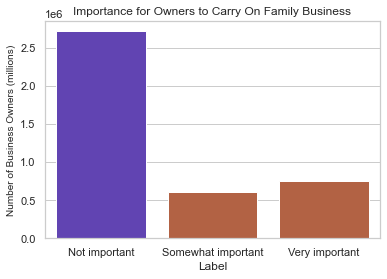

In [67]:
ax = sns.barplot(x=familyowned['Label'], y=familyowned['OWNPDEMP'], palette=['#5932C4', '#C45932', '#C45932'], data=familyowned)
# ax.set_xlabel('Importance of Carrying on the Family Business', size=10)
ax.set_ylabel('Number of Business Owners (millions)', size=10)
ax.set_title('Importance for Owners to Carry On Family Business')

### Firms By Employee Numbers

Queried from Business Characteristics API dataset

In [68]:
us_char = pd.read_json(f'https://api.census.gov/data/2018/abscb?get=NAME,BUSCHAR,EMPSZFI,EMPSZFI_LABEL,FIRMPDEMP&for=us:*&NAICS2017=00&QDESC=B02&key={api_key}')
# Fixed Headers
us_char.columns = us_char.iloc[0]
us_char = us_char.iloc[1:].reset_index(drop=True)
# Changed Data Type and Ran Describe
us_char['FIRMPDEMP'] = us_char['FIRMPDEMP'].astype(int)
us_char.FIRMPDEMP.describe().astype(object)

count             60.0
mean     376244.033333
std      915096.769979
min               22.0
25%            7233.25
50%            34490.0
75%           244818.0
max          5722142.0
Name: FIRMPDEMP, dtype: object

In [69]:
# Limited to Needed Columns
us_char = us_char[['BUSCHAR', 'EMPSZFI_LABEL', 'FIRMPDEMP']]

# Queried firms with family and not family owned labels
char_query = us_char.query('(BUSCHAR == "BN" or BUSCHAR == "BM") and EMPSZFI_LABEL != "All firms"')
char_query.head()

,BUSCHAR,EMPSZFI_LABEL,FIRMPDEMP
7,BM,Firms with no employees,58025
8,BN,Firms with no employees,164836
13,BM,Firms with 1 to 4 employees,370201
14,BN,Firms with 1 to 4 employees,1038613
19,BM,Firms with 5 to 9 employees,158710


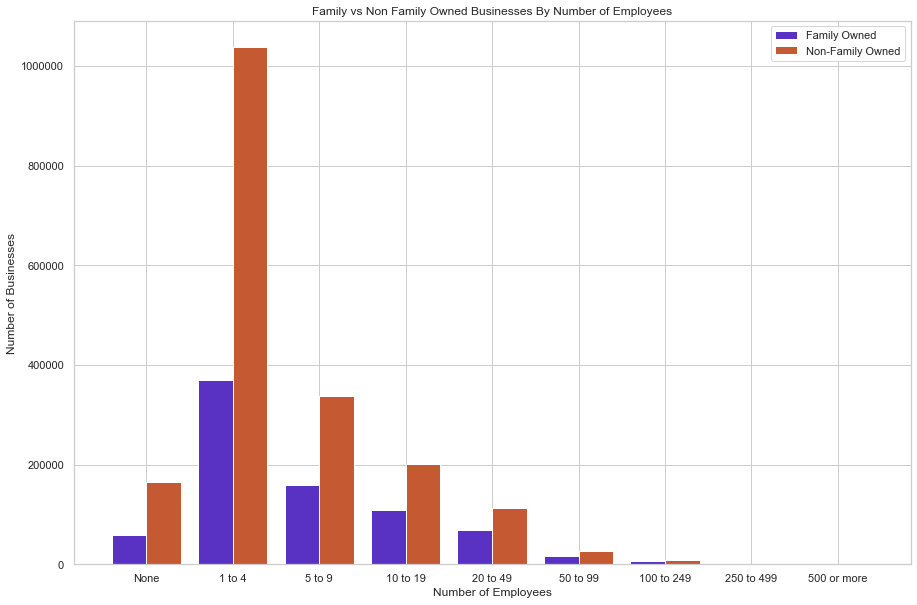

In [71]:
# Created separate dataframes for Family and Not Family Owned Businesses
family_query = char_query.query('BUSCHAR == "BM"')
nonfamily_query = char_query.query('BUSCHAR == "BN"')

# Plotted Bar Chart for Businesses By Number of Employees
plt.figure(figsize=(15, 10))
plt.ticklabel_format(style='plain')
plt.bar(np.arange(len(family_query)) - 0.2, family_query['FIRMPDEMP'], width=0.4, color='#5932C4', label='Family Owned')
plt.bar(np.arange(len(nonfamily_query)) + 0.2, nonfamily_query['FIRMPDEMP'], width=0.4, color='#C45932', label='Non-Family Owned')
# Created labels to make X axis easier to read
simple_labels= ['None', '1 to 4', '5 to 9', '10 to 19', '20 to 49', '50 to 99', '100 to 249', '250 to 499', '500 or more']
plt.xticks(range(len(family_query)), simple_labels)
plt.title('Family vs Non Family Owned Businesses By Number of Employees')
plt.xlabel('Number of Employees')
plt.ylabel('Number of Businesses')
plt.legend()

plt.show()

Being an aggragated dataset that was not designed around family owned businesses, we were limited in what information we could glean. The datasets were not easily mergeable either. If the datasets were redone tabulation based off family owned it would open it up further.